### Development of an LSTM-based methodology for burst detection in water distribution systems

This script was created by: Konstantinos Glynis as part of the thesis project entitled "Development of an LSTM-based methodology for burst detection in water distribution systems" of TU Delft in cooperation with Royal HaskoningDHV.

#### Import python packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import datetime
import itertools
from scipy.stats import percentileofscore, norm

import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, EarlyStopping, LearningRateScheduler

import utils

#### Script parameters

In [2]:
start_year = 2016  # options: 2016, 2018, 2020 [year]
DMA_number = 5

In [3]:
num_rolling_days = 2  # [days]
time_resolution = 15  # options: 15, 30, 60 [minutes]
weekday_time_resolution = time_resolution  # e.g., daily weekday labels
percentile_value = 99.9
test_size = 0.33

In [4]:
feature_list = ['Q', 'P', 'P_CP', 'TimeFeature1', 'Minute']
# feature_list = ['Q', 'P', 'TimeFeature1', 'Minute']  #                                         <--- Use this for P_CP to be excluded
leaks_included = 0  # options: 0 (don't include leaks on training), 1 (include leaks on training)
fire_hydrants = False
fine_tuning = False
multiple_Ps = True  # boolean; option for including P signals from multiple sensors just for DMAs with fire hydrant leak tests
ANN_type = 3  # options: 0 (Autoencoder), 1 (LSTM Autoencoder), 2 (Encoder-Decoder), 3 (LSTM)

In [5]:
data_start = "1/8/2021"
data_end = "1/1/2022"
test_start = "1/11/2021"

In [6]:
if (fine_tuning == True) | (multiple_Ps == True):
    multiple_Ps = True
    data_start = "1/1/2022"
    data_end = "28/3/2022"
    test_start = "1/3/2022"

#### Data loading

In [7]:
directory_path = os.getcwd()
DMA_list = os.listdir(directory_path + "\Sample datasets")
print(f'Ávailable dataset files: \n{DMA_list}\n')
print(f'DMA selected: {DMA_list[int(DMA_number)]}')

dataset_list = os.listdir(directory_path + "\Sample datasets" + '/' + DMA_list[int(DMA_number)])
indexCP = int(DMA_number * 2)
indexDM = indexCP + 1
filenameCP = directory_path + "\Sample datasets" + '/' + DMA_list[int(DMA_number)] + '/' + DMA_list[int(DMA_number)] + '_' + 'CP' + '.csv'
filenameDM = directory_path + "\Sample datasets" + '/' + DMA_list[int(DMA_number)] + '/' + DMA_list[int(DMA_number)] + '_' + 'DM' + '.csv'

Ávailable dataset files: 
['EFF13', 'HED14', 'HED22', 'HED35', 'LAN17', 'LAN34', 'MRK10', 'NOR22', 'OUT53', 'ROB12']

DMA selected: LAN34


In [8]:
P_ind = []; P_paths = []
num_features = len(feature_list)
if multiple_Ps==True:
    if DMA_list[int(DMA_number)] == 'HED14':
        num_features = num_features + 7  # take P signals from 7 additional sensors
    else:
        num_features = num_features + 5  # take P signals from 5 additional sensors
    for i in np.arange(1, (num_features - 4), 1):  #                                         <--- Use 3 instead of 4 for P_CP to be excluded
        P_path = 'P' + str(i) + '_path'
        P_ind.append(P_path[:2])
        locals()[P_path] = directory_path + "\Sample datasets" + '/' + DMA_list[int(DMA_number)] + '/' + DMA_list[int(DMA_number)] + '_' + 'P' + str(i) + '.csv'
        P_paths.append(locals()[P_path])

#### Dataframe and feature engineering

Data loading completed


C:\Users\921937\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


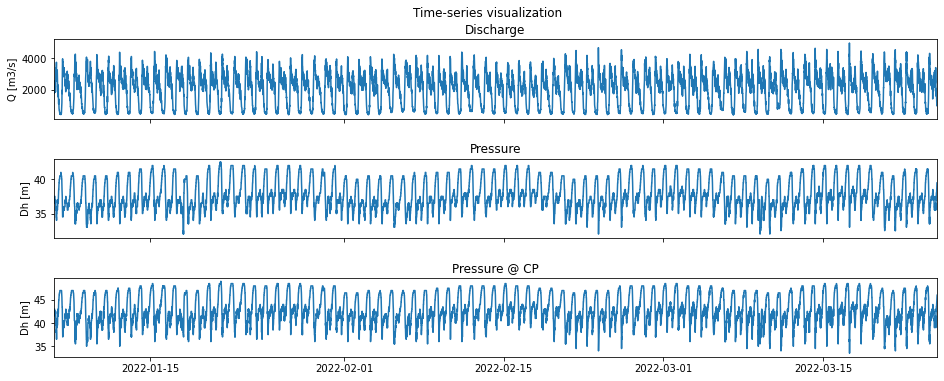

In [9]:
# Create dataframe with information from both the DMA entry and the Critical Point
df = utils.data_loading(filenameDM, filenameCP, P_ind, P_paths, start_year, time_resolution)
df = utils.data_features(df, time_resolution, verbose=False)
utils.initial_visualization(df)

# Load leak job records for selected DMA
import warnings
warnings.filterwarnings("ignore")
bursts = utils.load_leak_job_records(directory_path, DMA_list[int(DMA_number)], start_year, first_index=df.index[0], verbose=False)

In [10]:
if DMA_number == 1:
    bursts.loc[len(bursts.index)] = ['2022/03/10 09:00', '2022/03/10 11:30', 'fire-hydrant leak test']
elif DMA_number == 3:
    bursts.loc[len(bursts.index)] = ['2022/03/10 13:00', '2022/03/10 15:30', 'fire-hydrant leak test']
elif DMA_number == 5:
    bursts.loc[len(bursts.index)] = ['2022/03/15 13:00', '2022/03/15 15:30', 'fire-hydrant leak test']

In [11]:
# Flag dataframe entries within 0-day(s) of a known burst
day_num = 0
df = utils.leak_flagging(df, bursts, day_num, verbose=True)

Shape of dataframe entries with burst: (11, 13)
Shape of dataframe entries without burst: (7426, 13)


#### Data transformation

In [12]:
# Define length of time AE sees, e.g., 1 week
time_win_len = int((num_rolling_days * 24 * (60 / time_resolution)) + 1)

In [13]:
if fire_hydrants == True:
    if fine_tuning == False:
        df = df.iloc[np.where(df.index > datetime.datetime.strptime(data_start,"%d/%m/%Y"))[0]]
        df = df.iloc[np.where(df.index < datetime.datetime.strptime(data_end,"%d/%m/%Y"))[0]]
        if leaks_included == 0:  # don't include leaks on training
            train_val_indices = np.where(df['Burst'].iloc[np.where(df.index < datetime.datetime.strptime(test_start,"%d/%m/%Y"))[0]] == 0)[0]          
        test_indices = np.where((df.index >= datetime.datetime.strptime(test_start,"%d/%m/%Y")) & (df.index < datetime.datetime.strptime(data_end,"%d/%m/%Y")))[0]
    else:  # fine_tuning == True
        df = df.iloc[np.where(df.index > datetime.datetime.strptime(data_start,"%d/%m/%Y"))[0]]
        df = df.iloc[np.where(df.index < datetime.datetime.strptime(data_end,"%d/%m/%Y"))[0]]
        if leaks_included == 0:  # don't include leaks on training
            train_val_indices = np.where(df['Burst'].iloc[np.where(df.index < datetime.datetime.strptime(test_start,"%d/%m/%Y"))[0]] == 0)[0]
        test_indices = np.where((df.index >= datetime.datetime.strptime(test_start,"%d/%m/%Y")) & (df.index < datetime.datetime.strptime(data_end,"%d/%m/%Y")))[0]
else:  # fire_hydrants == False
    df = df.iloc[np.where(df.index >= datetime.datetime.strptime(data_start,"%d/%m/%Y"))[0]]
    if leaks_included == 0:  # don't include leaks on training
        train_val_indices = np.where(df['Burst'].iloc[np.where(df.index < datetime.datetime.strptime(test_start,"%d/%m/%Y"))[0]] == 0)[0]
    test_indices = np.where((df.index >= datetime.datetime.strptime(test_start,"%d/%m/%Y")) & (df.index < datetime.datetime.strptime(data_end,"%d/%m/%Y")))[0]
            
data_train_val, bool_array_train_val = utils.extract_rolling_weeks(df.iloc[train_val_indices], feature_list, P_ind, num_rolling_days, time_win_len, num_features, verbose=False)
data_test, bool_array_test = utils.extract_rolling_weeks(df.iloc[test_indices], feature_list, P_ind, num_rolling_days, time_win_len, num_features, verbose=False)

In [14]:
length_temp = len(np.where(bool_array_train_val == True)[0])
train_indices = train_val_indices[:int(length_temp * (1 - test_size))]
val_indices = train_val_indices[int(length_temp * (1 - test_size)):]

In [15]:
x_train, x_val = train_test_split(data_train_val, shuffle=False, test_size=test_size)
x_train = x_train[:-time_win_len]  # remove overlap between training and validation sets
x_test = data_test
print('Train-validation-test split completed')

# Scale and reshape train, validation and testing subsets
x_train, x_val, x_test, scaler_list = utils.scaling3D(x_train, x_val, x_test, num_features, verbose=True)

if ANN_type == 0:
    x_train, x_val, x_test = utils.reshape3D_to_2D(x_train, x_val, x_test)
elif ANN_type == 2:
    x1_train, x1_val, x1_test = utils.reshape3D_to_2D(x_train[:,:,:3], x_val[:,:,:3], x_test[:,:,:3])
    x2_train, x2_val, x2_test = utils.reshape3D_to_2D(x_train[:,:,3:], x_val[:,:,3:], x_test[:,:,3:])
    if weekday_time_resolution != time_resolution:
        x2_train, x2_val, x2_test = utils.feature_resampling(x2_train, x2_val, x2_test, time_win_len, weekday_time_resolution, time_resolution, verbose=True)
elif ANN_type == 3:
    y_train, y_val, y_test = x_train[:,-1,:-2], x_val[:,-1,:-2], x_test[:,-1,:-2]

Train-validation-test split completed
Data scaling completed
x_train: (3116, 193, 10)   x_val: (1630, 193, 10)   x_test: (2112, 193, 10)


#### Neural Network

In [16]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.0010)
er_stopping = EarlyStopping(monitor="val_loss", min_delta=0.0010, patience=10, verbose=1, mode="auto", restore_best_weights=True)

In [17]:
# Set up, train and test the model
if ANN_type==0:
    autoencoder = utils.create_AE(x_train, verbose=True)
    autoencoder, history = utils.train_AE(autoencoder, x_train, x_val, reduce_lr, er_stopping, verbose=2, epochs=100)
    x_train_pred, x_val_pred, x_test_pred = utils.predict_AE(autoencoder, x_train, x_val, x_test)
elif ANN_type==1:
    autoencoder = utils.create_LSTM_AE(x_train, time_win_len, verbose=True)
    autoencoder, history = utils.train_AE(autoencoder, x_train, x_val, reduce_lr, er_stopping, verbose=2, epochs=50)
    x_train_pred, x_val_pred, x_test_pred = utils.predict_AE(autoencoder, x_train, x_val, x_test)
elif ANN_type==2:
    autoencoder = utils.create_ED(x1_train, x2_train, verbose=True)
    autoencoder, history = utils.train_ED(autoencoder, x1_train, x2_train, x1_val, x2_val, reduce_lr, er_stopping, verbose=0, epochs=100)
    x_train_pred, x_val_pred, x_test_pred = utils.predict_ED(autoencoder, x1_train, x1_val, x1_test, x2_train, x2_val, x2_test)
else:
    if fine_tuning == False:
        autoencoder = utils.create_LSTM(x_train, y_train, num_features, dropout_rate=0.2, verbose=True)
        autoencoder, history = utils.train_LSTM(autoencoder, x_train, x_val, y_train, y_val, reduce_lr, er_stopping, verbose=2, verbose_print=False, epochs=100)
        y_train_pred, y_val_pred, y_test_pred = utils.predict_LSTM(autoencoder, x_train, x_val, x_test)
        autoencoder.save("LSTM_model")
    else:
        pre_trained_model = load_model("LSTM_model")
        autoencoder = utils.create_expanded_LSTM(x_train, y_train, num_features, dropout_rate=0.2, verbose=True)
        autoencoder = utils.transfer_learning(pre_trained_model, num_features, autoencoder)
        autoencoder, history = utils.train_LSTM(autoencoder, x_train, x_val, y_train, y_val, reduce_lr, er_stopping, verbose=2, verbose_print=False, epochs=100)
        y_train_pred, y_val_pred, y_test_pred = utils.predict_LSTM(autoencoder, x_train, x_val, x_test)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input1 (InputLayer)            [(None, 192, 8)]     0           []                               
                                                                                                  
 Input2 (InputLayer)            [(None, 2)]          0           []                               
                                                                                                  
 LSTM (LSTM)                    (None, 16)           1600        ['Input1[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 2)            6           ['Input2[0][0]']                 
                                                                                              

INFO:tensorflow:Assets written to: LSTM_model\assets


INFO:tensorflow:Assets written to: LSTM_model\assets


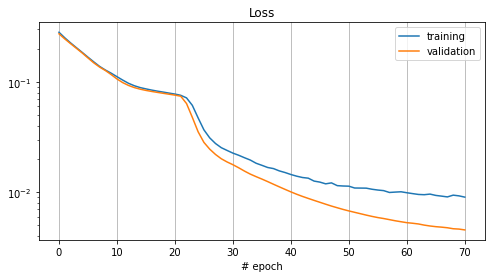

In [18]:
plt.figure(figsize=(8, 4))
plt.semilogy(history.history['loss'], label='training')
plt.semilogy(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.grid(axis='x'); plt.legend(); plt.xlabel('# epoch');

#### Reconstruction error

------- MSE -------
Training:   0.0061
Validation: 0.0053
Testing:    0.0078


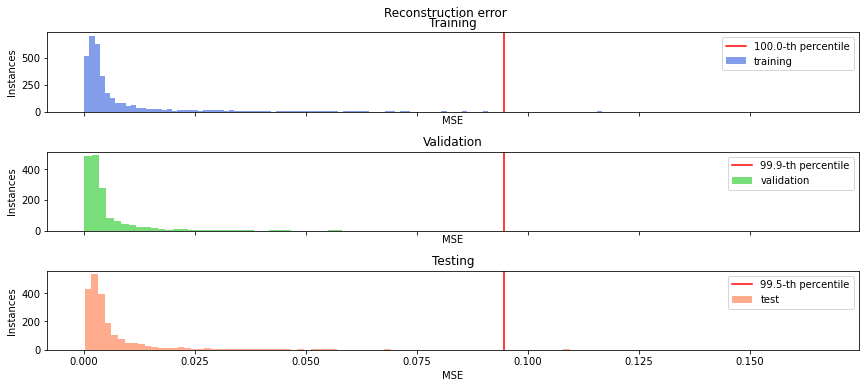

In [19]:
# Calculate reconstruction error
if ANN_type==0:
    MSE_train, MSE_val, MSE_test = utils.MSE_calc(x_train, x_val, x_test, x_train_pred, x_val_pred, x_test_pred, verbose=True)
elif ANN_type==1:
    x_train, x_val, x_test = utils.reshape3D_to_2D(x_train, x_val, x_test)
    x_train_pred, x_val_pred, x_test_pred = utils.reshape3D_to_2D(x_train_pred, x_val_pred, x_test_pred)
    MSE_train, MSE_val, MSE_test = utils.MSE_calc(x_train, x_val, x_test, x_train_pred, x_val_pred, x_test_pred, verbose=True)
elif ANN_type==2:
    MSE_train, MSE_val, MSE_test = utils.MSE_calc(x1_train, x1_val, x1_test, x_train_pred, x_val_pred, x_test_pred, verbose=True)
else:
    MSE_train, MSE_val, MSE_test = utils.MSE_calc(y_train, y_val, y_test, y_train_pred, y_val_pred, y_test_pred, verbose=True)
mse_perc = utils.MSE_hist(MSE_train, MSE_val, MSE_test, percentile_value)

In [20]:
bool_array = np.zeros(len(df)).astype(dtype=bool)
for i in range(0, int(len(bool_array) - time_win_len)):
    if df.index[i + time_win_len - 1] == df.index[i] + datetime.timedelta(days=num_rolling_days):
        bool_array[i] = True
valid_array = np.where(bool_array)[0]  # measurements that are followed by a week of continuous measurements

data_all, _ = utils.extract_rolling_weeks(df, feature_list, P_ind, num_rolling_days, time_win_len, num_features, verbose=False)

data_all_scaled = []
for i in range(len(scaler_list)):
    data_all_scaled.append(np.array([scaler_list[i].transform(data_all[:, :, i])])[0])
data_all = np.stack(data_all_scaled, axis=2)
    
# Reshape all data
if ANN_type==0:
    data_all = data_all.reshape(data_all.shape[0], data_all.shape[1] * data_all.shape[2])
elif ANN_type==2:
    data1_all = data_all[:,:,:3].reshape(data_all[:,:,:3].shape[0], data_all[:,:,:3].shape[1] * data_all[:,:,:3].shape[2])
    data2_all = data_all[:,:,3:].reshape(data_all[:,:,3:].shape[0], data_all[:,:,3:].shape[1] * data_all[:,:,3:].shape[2])
    if weekday_time_resolution != time_resolution:
        data2_all = utils.one_resampling(data2_all, time_win_len, weekday_time_resolution, time_resolution)

# Predict all data
if ANN_type<=1:
    data_all_pred = utils.predict_AE_one(autoencoder, data_all)
elif ANN_type==2:
    data_all_pred = utils.predict_ED_one(autoencoder, data1_all, data2_all)
else:
    data_all_pred = utils.predict_LSTM_one(autoencoder, data_all[:, :-1, :-2], data_all[:, -1, -2:])
    
if ANN_type==1:
    data_all = data_all.reshape(data_all.shape[0], data_all.shape[1] * data_all.shape[2])
    data_all_pred = data_all_pred.reshape(data_all_pred.shape[0], data_all_pred.shape[1] * data_all_pred.shape[2])

# Store MSE values in dataframe
df['MSE'] = np.zeros(len(df))
if ANN_type<=1:
    df['MSE'].iloc[valid_array + time_win_len] = utils.MSE_calc_one(data_all, data_all_pred)
elif ANN_type==2:
    df['MSE'].iloc[valid_array + time_win_len] = utils.MSE_calc_one(data1_all, data_all_pred)
else:
    df['MSE'].iloc[valid_array + time_win_len] = utils.MSE_calc_one(data_all[:,-1,:-2], data_all_pred)
df['MSE'].replace(0, np.nan, inplace=True)

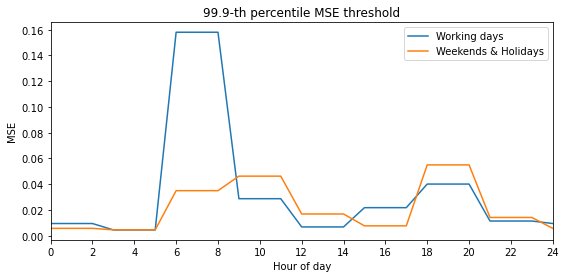

In [21]:
# Derive variable MSE threshold and store in dataframe
hour_intervals = 3
MSE_perc, working_days, weekends_holidays, val_indices = utils.Variable_MSE(df, percentile_value, train_val_indices, bool_array_train_val, time_win_len, x_val, hour_intervals, verbose=True)
df['MSE_thres'] = np.zeros(len(df))
for i, group_indices in enumerate([working_days, weekends_holidays]):
    for j in range(24):
        df['MSE_thres'].iloc[np.intersect1d(np.where(df.index.hour==j)[0], group_indices)] = MSE_perc[i, int(np.floor(j / hour_intervals))]

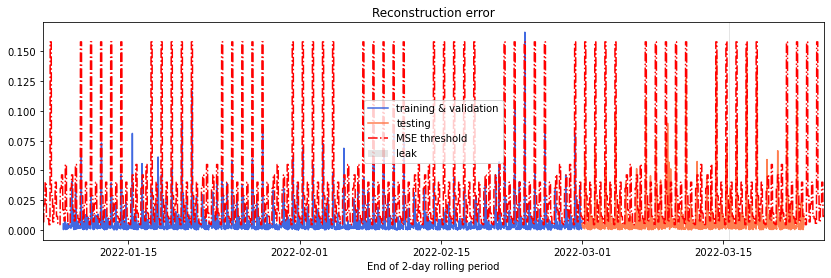

In [22]:
# Visualize MSE
utils.MSE_plot(df, bursts, train_val_indices, test_indices, valid_array, time_win_len, MSE_perc, num_rolling_days)

#### Performance

In [24]:
# Quantify performance
BattLeDIM = False
DMA_text=DMA_list[DMA_number][0:5]
det_leaks_ind, det_leaks_time = utils.performance_v3(df, bursts, train_indices, val_indices, test_indices, time_resolution, time_win_len, BattLeDIM, DMA_text, horizon_time=7, verbose=True)


-------------- LAN34 ---------------

--------- event-based KPIs ---------
No. bursts = 1 | Precision_e = 2.13% | Recall_e = 100.00%

--------- value-based KPIs ---------
TPR = 27.27% | FPR = 3.44% | Precision = 3.66%


In [25]:
# Night flow analysis
df['NFA'] = np.zeros(len(df))
NF_indices = np.where((df.index.hour >= 2) & (df.index.hour <= 4))[0]

for i in range(len(NF_indices)):
    past_data_indices = NF_indices[max(0, i - (30 * int(3 * (60 / time_resolution)))):i+1]
    df['NFA'][past_data_indices[-1]] = percentileofscore(df.Q[past_data_indices], df.Q[past_data_indices[-1]])

# Fill in day-time values with interpolation
df['NFA'].replace(0, np.nan, inplace=True)
df['NFA'] = df['NFA'].ffill(axis = 0)
# df['NFA'] = df['NFA'].interpolate(method='linear', limit_direction='forward', axis=0)

#### Individual leaks

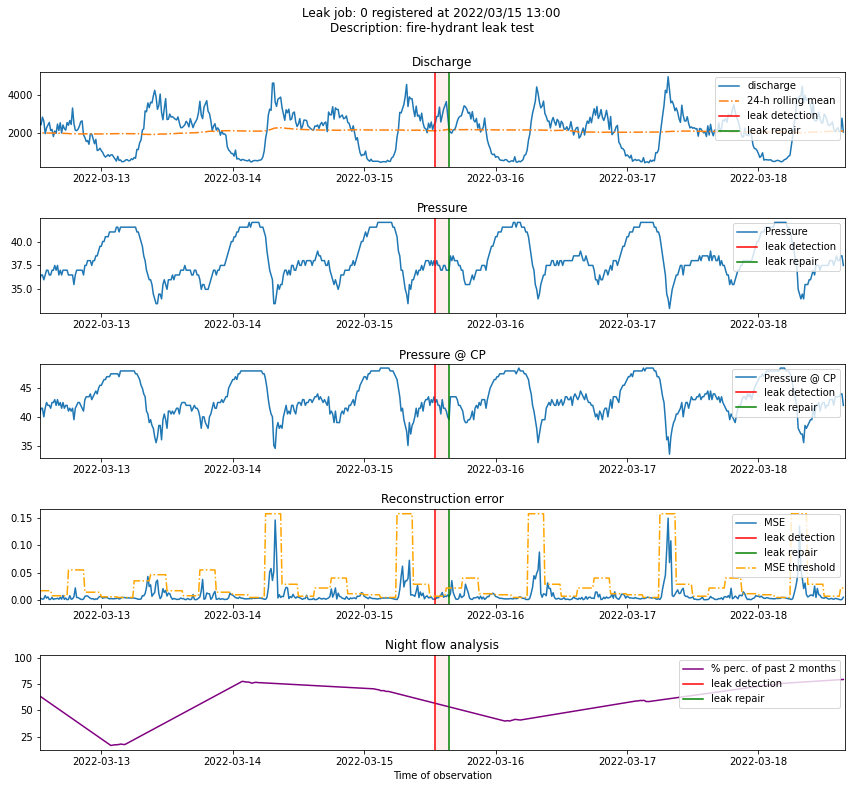

In [28]:
# Visualize single leak job
burst_index = 0  # 3, 14, 15, 25, 28, 40, 48, 64, 67, 76, 78 

burst_detection_index, burst_repair_index, plot_start_index, plot_end_index = utils.individual_leak_plot(
    burst_index, df, bursts, MSE_perc, num_rolling_days, int((3 * 24 * (60 / time_resolution)) + 1), time_resolution)

#### Data exploration

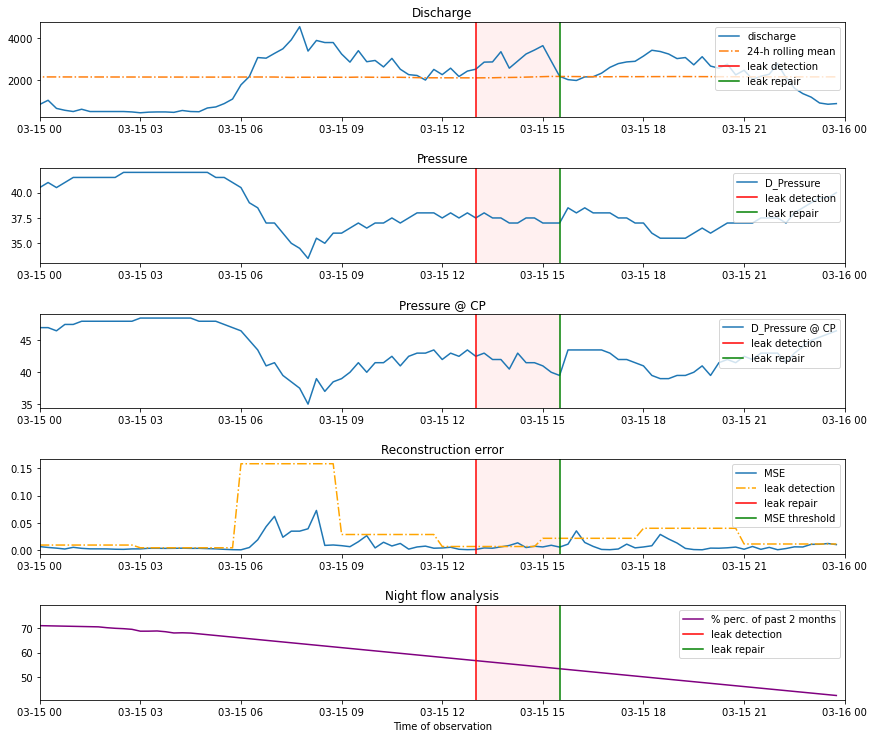


Leak jobs visualized:

* Leak job no.0 with index: 0 registered at 2022/03/15 13:00
  Description: fire-hydrant leak test



In [29]:
start_time = '2022-3-15'  # 2017-11-07
end_time = '2022-3-16'   # 2021-12-15

utils.data_explorer(df, bursts, MSE_perc, num_rolling_days, time_win_len, time_resolution, start_time, end_time, verbose=True)

#### Artificial leaks module

In [30]:
start_time = '2022-3-15'  # 2017-11-07
end_time = '2022-3-16'   # 2021-12-15

leak_start = datetime.datetime.strptime('2022-03-15 13:00',"%Y-%m-%d %H:%M")
leak_end = datetime.datetime.strptime('2022-03-15 15:30',"%Y-%m-%d %H:%M")

In [31]:
def bursts_in_timewindow(bursts, start_time, end_time):
    # Function that returns indices of bursts within a defined time window, set by start_time & end_time
    
    bursts_included = np.zeros(len(bursts))
    
    for j in range(len(bursts)):
        if (datetime.datetime.strptime(str(bursts.iloc[j, 1]),"%Y/%m/%d %H:%M") 
            >= datetime.datetime.strptime(str(start_time),"%Y-%m-%d")) & (
            datetime.datetime.strptime(str(bursts.iloc[j, 1]),"%Y/%m/%d %H:%M") 
            <= datetime.datetime.strptime(str(end_time),"%Y-%m-%d")) | (
            (datetime.datetime.strptime(str(bursts.iloc[j, 0]),"%Y/%m/%d %H:%M") 
            >= datetime.datetime.strptime(str(start_time),"%Y-%m-%d")) & (
            datetime.datetime.strptime(str(bursts.iloc[j, 0]),"%Y/%m/%d %H:%M") 
            <= datetime.datetime.strptime(str(end_time),"%Y-%m-%d"))):

            bursts_included[j] = 1
            
    return np.where(bursts_included == 1)[0]

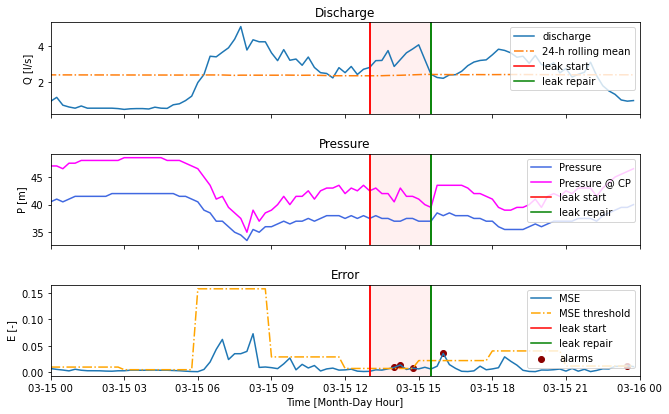


Leak jobs visualized:

* Leak job no.0 with index: 0 registered at 2022/03/15 13:00
  Description: fire-hydrant leak test



In [32]:
plot_start_index = max(np.where(df.index >= start_time)[0][0], 0)
plot_end_index = min(np.where(df.index >= end_time)[0][0], len(df))

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(9, 5.5))
f.tight_layout(h_pad=3)

ax1.plot(df['Q'].iloc[plot_start_index:plot_end_index] / (15 * 60), label='discharge');
ax1.plot(df['Q'].iloc[max(plot_start_index - time_win_len, 0):plot_end_index].rolling(int(24 * (60 / time_resolution))).mean() / (15 * 60), linestyle='-.', label='24-h rolling mean')
ax1.set_title('Discharge');
ax1.set_xlim([df.index[plot_start_index], df.index[plot_end_index]])
ax1.axvline(leak_start, color='r')
ax1.axvline(leak_end, color='g')
ax1.set_ylabel('Q [l/s]')
ax1.legend(['discharge', '24-h rolling mean', 'leak start', 'leak repair'], loc='upper right');

ax2.plot(df['P'].iloc[plot_start_index:plot_end_index], c='royalblue', label='Pressure');
ax2.plot(df['P_CP'].iloc[plot_start_index:plot_end_index], c='magenta', label='Pressure @ CP');
ax2.set_title('Pressure');
ax2.axvline(leak_start, color='r')
ax2.axvline(leak_end, color='g')
ax2.set_ylabel('P [m]')
ax2.legend(['Pressure', 'Pressure @ CP', 'leak start', 'leak repair'], loc='upper right');

ax3.plot(df['MSE'].iloc[plot_start_index:plot_end_index], label='MSE');
ax3.set_title('Error');
ax3.plot(df['MSE_thres'].iloc[plot_start_index:plot_end_index], color='orange', linestyle='-.', label='MSE threshold');
ax3.axvline(leak_start, color='r')
ax3.axvline(leak_end, color='g')
ax3.set_ylabel('E [-]')
alarm_boolean = np.where(df['MSE'].iloc[plot_start_index:plot_end_index] > df['MSE_thres'].iloc[plot_start_index:plot_end_index])[0]
ax3.scatter(df['MSE'].iloc[plot_start_index:plot_end_index][alarm_boolean].index, df['MSE'].iloc[plot_start_index:plot_end_index][alarm_boolean], marker='o', color='darkred')
# ax3.set_ylim([0, 0.3])

ax3.set_xlabel('Time [Month-Day Hour]');
# ax3.set_xlabel('Time [Year-Month-Day]');
ax3.legend(['MSE', 'MSE threshold', 'leak start', 'leak repair', 'alarms'], loc='upper right');

burst_indices = bursts_in_timewindow(bursts, start_time, end_time)

for j in range(len(burst_indices)):

    rows_burst_detection_boolean = (df.index >= datetime.datetime.strptime(str(bursts.iloc[burst_indices[j], 0]),"%Y/%m/%d %H:%M"))
    burst_detection_index = np.where(rows_burst_detection_boolean)[0][0]
    rows_burst_repair_boolean = (df.index >= datetime.datetime.strptime(str(bursts.iloc[burst_indices[j], 1]),"%Y/%m/%d %H:%M"))
    burst_repair_index = np.where(rows_burst_repair_boolean)[0][0]

    ax1.axvspan(df.index[burst_detection_index], df.index[burst_repair_index], color='red', alpha=0.06, lw=0)
    ax2.axvspan(df.index[burst_detection_index], df.index[burst_repair_index], color='red', alpha=0.06, lw=0)
    ax3.axvspan(df.index[burst_detection_index], df.index[burst_repair_index], color='red', alpha=0.06, lw=0)

    ax1.axvline(df.index[burst_detection_index], color='r', label='leak detection');
    ax2.axvline(df.index[burst_detection_index], color='r', label='leak detection');
    ax3.axvline(df.index[burst_detection_index], color='r', label='leak detection');

    ax1.axvline(df.index[burst_repair_index], color='g', label='leak repair');
    ax2.axvline(df.index[burst_repair_index], color='g', label='leak repair');
    ax3.axvline(df.index[burst_repair_index], color='g', label='leak repair');

plt.show()

if len(burst_indices > 0):
    print('\033[1m' + '\nLeak jobs visualized:\n' + '\033[0m')

for j in range(len(burst_indices)):
    print(f'* Leak job no.{burst_indices[j]} with index: {bursts.index[burst_indices[j]]} registered at {bursts.iloc[burst_indices[j], 0]}\n  Description: {bursts.iloc[burst_indices[j], 2]}\n')